author: Xue (Lily) Yang, git@lilyportfolio

# Importing Libraries



In [ ]:
#These libraries help to interact with the operating system and the runtime environment respectively
import os
import sys

#Model/Training related libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
import csv
import pandas as pd
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#Dataloader libraries
from torch.utils.data import DataLoader, Dataset

In [ ]:
if __name__ == '__main__':
    #GPU Check
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    num_workers = 8 if cuda else 0
    print('Cuda = ', cuda, 'num of workers =', num_workers, "system version = ", sys.version)

Cuda =  True num of workers = 8 system version =  3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]


In [ ]:
torch.cuda.empty_cache()
random.seed(1234)

In [ ]:
!nvidia-smi

Sat Dec  4 21:04:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P2    36W / 151W |   2669MiB /  8097MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tuning args

In [ ]:
tuning_args = {
    'batch_size': 512,
    'num_epochs': 100
    }

# Setting up Data

## 1. Load Data and Data Preprocessing

### Separate Clusters

### Parse data points and split

In [ ]:
colnames = pd.read_csv("psam_pusa_colnames.csv")
#|MARHYP
qii_indices = colnames[colnames.iloc[:, 1].str.match('AGEP')]
qii_indices_list = qii_indices.iloc[:, 0].tolist()
print(qii_indices_list)

cluster_low = np.load('cluster_low/cluster_low_array.npy')
print(cluster_low.shape)
qii_strata = cluster_low[:, qii_indices_list]

[2]
(50002, 5091)


In [ ]:
# Cluster stratification using one feature
from sklearn.model_selection import train_test_split
X = np.array(np.nan_to_num(np.delete(cluster_low, 19, axis=1)))
y = np.array(np.nan_to_num(np.log(cluster_low[:, 19], where=cluster_low[:, 19]>0)))
qii_strata = X[:, qii_indices_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9,test_size=0.1, random_state=123, stratify = qii_strata)

### Separate into clusters

### Data Removal

In [ ]:
import csv
data = pd.read_csv("psam_pusa_colnames.csv") 

#### Remove income related columns

In [ ]:
numeric_indices = data[~data.iloc[:, 1].str.contains('PINCP|INTP|OIP|PAP|RETP|SEMP|SSIP|SSP|WAGP|PERNP', regex=True)]

#### >60% null values

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('GCM_|DRAT_|SFN_|SFR_|NOP_|ESP_|GCR_|FHINS5C_|FOD2P_|MLPK_|MLPJ_|VPS_|MLPB_|MLPH_|MLPFG_|MLPE_\
                                                                           |MLPCD_|MLPI_|CITWP_|DRATX_|SCHG_|MIGSP_|MIGPUMA_|FHINS4C_|YOEP|DECADE_|ENG_|LANP_|FER_\
                                                                           |FHINS3C_|SCIENGRLP_|SCIENGP_', regex=True)]

#### Drop Flags > 99%

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FANCP|FDRATP|FDRATXP|FGCLP|FGCMP|FMILPP|FWRKP|FSEXP', regex=True)]

#### Drop Redundant Flags

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FYOEP|FWKHP|FWAGP|FSSP|FSSIP|FSEMP|FRETP|FRELSHIPP|FPOWSP|FPOBP|FPINCP|FPERNP|FPAP|FOIP|FOCCP\
                                                                           |FMIGSP|FMARHYP|FLANP|FJWRIP|FJWMNP|FJWDP|FINTP|FINDP|FHISP|FCITWP|FAGEP', regex=True)]

In [ ]:
numeric_indices_list = numeric_indices.iloc[:, 0].tolist()

## 2. Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, i):
        
        preprocessed_X = self.X[i]
        preprocessed_Y = self.Y[i]
        
        # ignore data that have age under 16
        age = int(preprocessed_X[2])

        if age >= 16:
            X = np.array(preprocessed_X[numeric_indices_list])
            Y = np.array(preprocessed_Y)
            return torch.FloatTensor(X), torch.FloatTensor(Y)

def my_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))    
    return torch.utils.data.dataloader.default_collate(batch)

## 3. Initialize Dataloader

In [ ]:
# Training dataloader
train_data = CustomDataset(X_train, y_train)
train_args = dict(shuffle = True, batch_size = tuning_args['batch_size'], num_workers=8)
train_loader = DataLoader(train_data, **train_args, collate_fn=my_collate)

# Validation dataloader
val_data = CustomDataset(X_test, y_test)
val_args = dict(shuffle = False, batch_size = tuning_args['batch_size'], num_workers=8)
val_loader = DataLoader(val_data, **val_args, collate_fn=my_collate)

In [ ]:
print(len(train_data[0][0]))

4339


# Build Model

## 1. OLS

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X_train = []
y_train = []

for i in range(10000):
    if train_data[i] is not None:
        X_train.append(train_data[i][0].numpy())
        # y_train.append(train_data[i][1].numpy())

print(len(X_train))

9782


## 2. SVD

In [ ]:
from scipy.linalg import svd

svd_array = np.array(X_train)
U, s, VT = svd(svd_array, full_matrices = False)

In [ ]:
model_args = {
    'learning_rate': 5e-4, #5e-4 -model2, #0.001 - model1,
    'model_num': '6',
    'model_size': [len(train_data[0][0]), 10000, 1]
    }

## 3. MLP - no hidden

## 4. MLP

In [ ]:
class MLP(nn.Module):

    # define model elements
    def __init__(self, size):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(size[0], size[0]), 
                                   # nn.BatchNorm1d(size[0]),
                                   nn.ReLU(),
                                   # nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[0], size[1]),
                                   # nn.BatchNorm1d(size[1]),
                                   # nn.ReLU(),
                                   nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[1], size[2]))

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
model = MLP(model_args['model_size'])
model.weight = s
model.to(device)

# Define Criterion/ Loss function
criterion = nn.MSELoss()

# Define Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = model_args['learning_rate'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=4339, out_features=4339, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4339, out_features=10000, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10000, out_features=1, bias=True)
  )
)


# Run

## 1. Train

In [ ]:
def train_model(train_loader, model):
    training_loss = 0.0
    
    # Set model in 'Training mode'
    model.train()
    
    start_time = time.time()
    
    # enumerate mini batches
    for i, (inputs, targets) in tqdm(enumerate(train_loader), position=0, leave=True):
        # clear the gradients
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the model output
        out = model(inputs).squeeze()
        
        # calculate loss
        loss = criterion(out, targets)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()

        training_loss += loss.item()
        
        end_time = time.time()
    
    training_loss /= len(val_loader)
    
    print('Training loss: {:.5f}, Time: {}s'.format(training_loss, end_time - start_time))
    
    return training_loss

## 2. Eval

In [ ]:
def evaluate_model(val_loader, model):
    
    batch_count = 0
    running_loss = 0.0
    predictions_list = []
    targets_list = []
    
    # Set model in validation mode
    with torch.no_grad():
        
        model.eval()
        model.to(device)
        
        for i, (inputs, targets) in tqdm(enumerate(val_loader), position=0, leave=True):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # evaluate the model on the validation set
            out = model(inputs).squeeze()
            
            # Calculate validation loss
            loss = criterion(out, targets)
        
            pred = out.data
            
            batch_count += targets.size(0)
            running_loss += loss.item()
            
            pred_cpu = pred.detach().cpu().numpy()
            target_cpu = targets.view(-1).detach().cpu().numpy()
            
            predictions_list.append(pred_cpu)
            targets_list.append(target_cpu)
            
            running_loss /= batch_count
        
        print('Validation loss: {:.5}'.format(running_loss))
        
    return running_loss, predictions_list, targets_list

## 3. OLS - run

## 4. MLP - run

In [ ]:
epochs = tuning_args['num_epochs']

final_r2 = 0.0
training_loss_list = []
val_loss_list = []
r2_list = []

for epoch in range(epochs):
    print('Epoch #{}'.format(epoch+1))
    start_time = time.time()
    
    # Train
    training_loss = train_model(train_loader, model)
    training_loss_list.append(training_loss)

    # Validation
    val_loss, pred_list, target_list = evaluate_model(val_loader, model)
    val_loss_list.append(val_loss)
    
    pred_flat = np.concatenate([x.ravel() for x in pred_list])
    target_flat = np.concatenate([x.ravel() for x in target_list])

    set_r2 = r2_score(pred_flat, target_flat)
    r2_list.append(set_r2)
    
    # scheduler (to allow learning rate to change)
    scheduler.step()

    #if at a particular epoch, save model
    if set_r2 > final_r2:

        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict()
        }

        torch.save(checkpoint, 'model'+ model_args['model_num'] + '_' + str(epoch+1) + '_' + str(set_r2) + '.pth')
        
        final_r2 = set_r2
    
    end_time = time.time()
    
    print('Set R2:{:.5f}, Epoch Time: {}s'.format(set_r2, end_time - start_time))
    print('='*60)

print('MLP Done')

Epoch #1


88it [00:06, 14.22it/s]

Training loss: 222.90093, Time: 6.411970853805542s



10it [00:00, 27.35it/s]

Validation loss: 0.0022797
Set R2:-58.75841, Epoch Time: 7.119301080703735s
Epoch #2



88it [00:06, 14.40it/s]

Training loss: 101.76519, Time: 6.35055136680603s



10it [00:00, 30.28it/s]

Validation loss: 0.0013845
Set R2:-1.95553, Epoch Time: 7.037281274795532s
Epoch #3



88it [00:06, 14.29it/s]

Training loss: 71.82128, Time: 6.4074060916900635s



10it [00:00, 32.91it/s]

Validation loss: 0.001183
Set R2:-0.29857, Epoch Time: 7.076109886169434s
Epoch #4



88it [00:06, 14.34it/s]

Training loss: 57.89779, Time: 6.415040731430054s



10it [00:00, 26.73it/s]


Validation loss: 0.0013497
Set R2:0.32746, Epoch Time: 8.20409893989563s
Epoch #5


88it [00:06, 14.32it/s]

Training loss: 49.84133, Time: 6.375751733779907s



10it [00:00, 28.59it/s]

Validation loss: 0.00098008
Set R2:0.23793, Epoch Time: 7.092271566390991s
Epoch #6



88it [00:06, 14.30it/s]

Training loss: 46.29468, Time: 6.419382095336914s



10it [00:00, 25.91it/s]


Validation loss: 0.00090403
Set R2:0.44361, Epoch Time: 8.232701063156128s
Epoch #7


88it [00:06, 14.43it/s]

Training loss: 43.25523, Time: 6.346247434616089s



10it [00:00, 27.90it/s]


Validation loss: 0.0008754
Set R2:0.46110, Epoch Time: 8.13114047050476s
Epoch #8


88it [00:06, 14.09it/s]

Training loss: 41.43614, Time: 6.437971830368042s



10it [00:00, 29.46it/s]

Validation loss: 0.00088538
Set R2:0.40492, Epoch Time: 7.163350582122803s
Epoch #9



88it [00:06, 14.31it/s]

Training loss: 39.90882, Time: 6.379033327102661s



10it [00:00, 29.47it/s]


Validation loss: 0.00087994
Set R2:0.47564, Epoch Time: 8.121893167495728s
Epoch #10


88it [00:06, 14.38it/s]

Training loss: 39.09591, Time: 6.3741135597229s



10it [00:00, 28.02it/s]

Validation loss: 0.00087165
Set R2:0.45820, Epoch Time: 7.047068357467651s
Epoch #11



88it [00:06, 14.31it/s]

Training loss: 46.79978, Time: 6.410654783248901s



10it [00:00, 30.71it/s]

Validation loss: 0.00091653
Set R2:0.34068, Epoch Time: 7.076859951019287s
Epoch #12



88it [00:06, 14.28it/s]

Training loss: 45.46872, Time: 6.4038918018341064s



10it [00:00, 32.65it/s]


Validation loss: 0.0012299
Set R2:0.46205, Epoch Time: 7.045516729354858s
Epoch #13


88it [00:06, 14.41it/s]

Training loss: 44.68999, Time: 6.384730339050293s



10it [00:00, 29.68it/s]

Validation loss: 0.00089782
Set R2:0.43201, Epoch Time: 7.069952726364136s
Epoch #14



88it [00:06, 14.14it/s]

Training loss: 42.20138, Time: 6.451454401016235s



10it [00:00, 24.52it/s]

Validation loss: 0.00089442
Set R2:0.34633, Epoch Time: 7.164649486541748s
Epoch #15



88it [00:06, 14.30it/s]

Training loss: 39.89571, Time: 6.4135191440582275s



10it [00:00, 30.19it/s]

Validation loss: 0.00098419
Set R2:0.36802, Epoch Time: 7.097269773483276s
Epoch #16



88it [00:06, 14.20it/s]

Training loss: 38.87420, Time: 6.455503940582275s



10it [00:00, 29.48it/s]


Validation loss: 0.00087442
Set R2:0.44732, Epoch Time: 7.13965916633606s
Epoch #17


88it [00:06, 14.41it/s]

Training loss: 37.64086, Time: 6.3547375202178955s



10it [00:00, 27.95it/s]

Validation loss: 0.00087695
Set R2:0.43912, Epoch Time: 7.05250096321106s
Epoch #18



88it [00:06, 14.22it/s]

Training loss: 35.68520, Time: 6.425655364990234s



10it [00:00, 29.19it/s]


Validation loss: 0.0008436
Set R2:0.51048, Epoch Time: 8.202306270599365s
Epoch #19


88it [00:06, 14.30it/s]

Training loss: 34.31017, Time: 6.422755479812622s



10it [00:00, 30.91it/s]

Validation loss: 0.00088276
Set R2:0.46401, Epoch Time: 7.11626124382019s
Epoch #20



88it [00:06, 14.20it/s]

Training loss: 33.49844, Time: 6.436169147491455s



10it [00:00, 28.74it/s]

Validation loss: 0.00086272
Set R2:0.49484, Epoch Time: 7.113555192947388s
Epoch #21



88it [00:06, 14.26it/s]

Training loss: 41.14222, Time: 6.42416524887085s



10it [00:00, 30.80it/s]

Validation loss: 0.0010541
Set R2:0.46188, Epoch Time: 7.090736389160156s
Epoch #22



88it [00:06, 14.31it/s]

Training loss: 41.04956, Time: 6.425954580307007s



10it [00:00, 28.86it/s]


Validation loss: 0.00091632
Set R2:0.54148, Epoch Time: 8.180882453918457s
Epoch #23


88it [00:06, 14.39it/s]

Training loss: 41.32414, Time: 6.356674432754517s



10it [00:00, 29.69it/s]

Validation loss: 0.00093131
Set R2:0.33634, Epoch Time: 7.0062596797943115s
Epoch #24



88it [00:06, 14.41it/s]

Training loss: 38.10478, Time: 6.364165306091309s



10it [00:00, 26.80it/s]

Validation loss: 0.00095736
Set R2:0.48497, Epoch Time: 7.099152565002441s
Epoch #25



88it [00:06, 14.24it/s]

Training loss: 35.57294, Time: 6.422630310058594s



10it [00:00, 28.20it/s]

Validation loss: 0.00093062
Set R2:0.49765, Epoch Time: 7.100492238998413s
Epoch #26



88it [00:06, 14.17it/s]

Training loss: 34.35441, Time: 6.442618131637573s



10it [00:00, 27.85it/s]

Validation loss: 0.0010254
Set R2:0.30957, Epoch Time: 7.1215596199035645s
Epoch #27



88it [00:06, 14.13it/s]

Training loss: 32.40748, Time: 6.4815778732299805s



10it [00:00, 29.72it/s]

Validation loss: 0.00092534
Set R2:0.48685, Epoch Time: 7.146267890930176s
Epoch #28



88it [00:06, 14.25it/s]

Training loss: 30.46584, Time: 6.450676202774048s



10it [00:00, 27.77it/s]


Validation loss: 0.00093416
Set R2:0.43610, Epoch Time: 7.129330635070801s
Epoch #29


88it [00:06, 14.26it/s]

Training loss: 29.29417, Time: 6.41377067565918s



10it [00:00, 30.37it/s]

Validation loss: 0.0008909
Set R2:0.51610, Epoch Time: 7.093771696090698s
Epoch #30



88it [00:06, 14.22it/s]

Training loss: 28.42009, Time: 6.452571392059326s



10it [00:00, 30.13it/s]


Validation loss: 0.00091637
Set R2:0.50104, Epoch Time: 7.129605770111084s
Epoch #31


88it [00:06, 14.32it/s]

Training loss: 36.65491, Time: 6.3981099128723145s



10it [00:00, 27.89it/s]

Validation loss: 0.0010581
Set R2:0.49792, Epoch Time: 7.115072965621948s
Epoch #32



88it [00:06, 14.30it/s]

Training loss: 37.14755, Time: 6.39469838142395s



10it [00:00, 30.57it/s]

Validation loss: 0.0010773
Set R2:0.30618, Epoch Time: 7.064327955245972s
Epoch #33



88it [00:06, 14.33it/s]

Training loss: 38.08930, Time: 6.369369029998779s



10it [00:00, 26.87it/s]

Validation loss: 0.00099379
Set R2:0.53932, Epoch Time: 7.06570029258728s
Epoch #34



88it [00:06, 14.34it/s]

Training loss: 33.26896, Time: 6.3929994106292725s



10it [00:00, 27.90it/s]

Validation loss: 0.0010032
Set R2:0.48523, Epoch Time: 7.061251878738403s
Epoch #35



88it [00:06, 14.11it/s]

Training loss: 31.08918, Time: 6.448818206787109s



10it [00:00, 30.31it/s]


Validation loss: 0.00097644
Set R2:0.55101, Epoch Time: 8.20354437828064s
Epoch #36


88it [00:06, 14.13it/s]

Training loss: 30.16087, Time: 6.460008859634399s



10it [00:00, 29.72it/s]

Validation loss: 0.0011269
Set R2:0.50493, Epoch Time: 7.1520867347717285s
Epoch #37



88it [00:06, 14.22it/s]

Training loss: 29.36370, Time: 6.439273357391357s



10it [00:00, 28.83it/s]

Validation loss: 0.00096568
Set R2:0.49379, Epoch Time: 7.140583276748657s
Epoch #38



88it [00:06, 14.14it/s]

Training loss: 26.13012, Time: 6.475906133651733s



10it [00:00, 28.86it/s]

Validation loss: 0.00097771
Set R2:0.52040, Epoch Time: 7.160816669464111s
Epoch #39



88it [00:06, 14.41it/s]

Training loss: 25.03458, Time: 6.401883363723755s



10it [00:00, 29.28it/s]

Validation loss: 0.00097998
Set R2:0.52438, Epoch Time: 7.087411403656006s
Epoch #40



88it [00:06, 14.25it/s]

Training loss: 24.18518, Time: 6.437876462936401s



10it [00:00, 32.16it/s]

Validation loss: 0.00098062
Set R2:0.51402, Epoch Time: 7.092670202255249s
Epoch #41



88it [00:06, 14.10it/s]

Training loss: 36.62053, Time: 6.469419717788696s



10it [00:00, 28.78it/s]

Validation loss: 0.00090593
Set R2:0.47154, Epoch Time: 7.174239158630371s
Epoch #42



88it [00:06, 14.30it/s]

Training loss: 31.42168, Time: 6.401246786117554s



10it [00:00, 29.10it/s]

Validation loss: 0.00097824
Set R2:0.46683, Epoch Time: 7.081283092498779s
Epoch #43



88it [00:06, 14.42it/s]

Training loss: 32.44973, Time: 6.340801954269409s



10it [00:00, 29.03it/s]

Validation loss: 0.0011557
Set R2:0.45755, Epoch Time: 7.028352737426758s
Epoch #44



88it [00:06, 14.38it/s]

Training loss: 32.14986, Time: 6.373723983764648s



10it [00:00, 32.95it/s]

Validation loss: 0.0010123
Set R2:0.41728, Epoch Time: 7.030486345291138s
Epoch #45



88it [00:06, 14.38it/s]

Training loss: 28.52619, Time: 6.3750035762786865s



10it [00:00, 31.27it/s]

Validation loss: 0.0011876
Set R2:0.46700, Epoch Time: 7.051845073699951s
Epoch #46



88it [00:06, 14.36it/s]

Training loss: 25.72756, Time: 6.384362459182739s



10it [00:00, 27.60it/s]

Validation loss: 0.00099223
Set R2:0.39351, Epoch Time: 7.07332444190979s
Epoch #47



88it [00:06, 14.26it/s]

Training loss: 24.26443, Time: 6.406317710876465s



10it [00:00, 28.19it/s]

Validation loss: 0.0010517
Set R2:0.42980, Epoch Time: 7.131569147109985s
Epoch #48



88it [00:06, 14.37it/s]

Training loss: 22.62785, Time: 6.377877235412598s



10it [00:00, 31.62it/s]

Validation loss: 0.0010033
Set R2:0.47048, Epoch Time: 7.044741153717041s
Epoch #49



88it [00:06, 14.45it/s]

Training loss: 21.13877, Time: 6.323333263397217s



10it [00:00, 28.14it/s]

Validation loss: 0.0010225
Set R2:0.50518, Epoch Time: 7.046464204788208s
Epoch #50



88it [00:06, 14.39it/s]

Training loss: 20.53822, Time: 6.355202674865723s



10it [00:00, 28.91it/s]


Validation loss: 0.0010311
Set R2:0.50522, Epoch Time: 7.0488197803497314s
Epoch #51


88it [00:06, 14.47it/s]

Training loss: 30.36153, Time: 6.330926179885864s



10it [00:00, 31.89it/s]

Validation loss: 0.0011047
Set R2:0.51519, Epoch Time: 7.004047870635986s
Epoch #52



88it [00:06, 14.30it/s]

Training loss: 29.63799, Time: 6.399478435516357s



10it [00:00, 27.72it/s]

Validation loss: 0.001112
Set R2:0.15180, Epoch Time: 7.076845169067383s
Epoch #53



88it [00:06, 14.43it/s]

Training loss: 34.00282, Time: 6.367114782333374s



10it [00:00, 29.70it/s]

Validation loss: 0.00097477
Set R2:0.50466, Epoch Time: 7.053524017333984s
Epoch #54



88it [00:06, 14.31it/s]

Training loss: 26.34692, Time: 6.415499687194824s



10it [00:00, 27.68it/s]

Validation loss: 0.0010058
Set R2:0.47388, Epoch Time: 7.081478118896484s
Epoch #55



88it [00:06, 14.38it/s]

Training loss: 23.27233, Time: 6.3900065422058105s



10it [00:00, 30.31it/s]


Validation loss: 0.0011593
Set R2:0.52195, Epoch Time: 7.066100358963013s
Epoch #56


88it [00:06, 14.47it/s]

Training loss: 21.91787, Time: 6.3332085609436035s



10it [00:00, 30.03it/s]


Validation loss: 0.0010056
Set R2:0.53563, Epoch Time: 7.0097575187683105s
Epoch #57


88it [00:06, 14.42it/s]

Training loss: 20.64539, Time: 6.3823041915893555s



10it [00:00, 28.79it/s]

Validation loss: 0.0010459
Set R2:0.52035, Epoch Time: 7.07653021812439s
Epoch #58



88it [00:06, 14.38it/s]

Training loss: 18.98936, Time: 6.378041505813599s



10it [00:00, 30.40it/s]

Validation loss: 0.00107
Set R2:0.52367, Epoch Time: 7.066115617752075s
Epoch #59



88it [00:06, 14.44it/s]

Training loss: 18.06797, Time: 6.35400652885437s



10it [00:00, 29.93it/s]

Validation loss: 0.0010933
Set R2:0.52801, Epoch Time: 7.040225028991699s
Epoch #60



88it [00:06, 14.34it/s]

Training loss: 17.30649, Time: 6.384449005126953s



10it [00:00, 28.14it/s]

Validation loss: 0.0010746
Set R2:0.51256, Epoch Time: 7.069138765335083s
Epoch #61



88it [00:06, 14.32it/s]

Training loss: 25.72449, Time: 6.385915040969849s



10it [00:00, 30.13it/s]


Validation loss: 0.0010877
Set R2:0.54217, Epoch Time: 7.060051918029785s
Epoch #62


88it [00:06, 14.29it/s]

Training loss: 26.77153, Time: 6.405793190002441s



10it [00:00, 28.62it/s]

Validation loss: 0.0011373
Set R2:0.25120, Epoch Time: 7.111977577209473s
Epoch #63



88it [00:06, 14.37it/s]

Training loss: 24.93067, Time: 6.401371240615845s



10it [00:00, 27.52it/s]

Validation loss: 0.0013748
Set R2:0.49422, Epoch Time: 7.111985921859741s
Epoch #64



88it [00:06, 14.41it/s]

Training loss: 22.78901, Time: 6.362658262252808s



10it [00:00, 34.15it/s]

Validation loss: 0.0011602
Set R2:0.52198, Epoch Time: 7.012911081314087s
Epoch #65



88it [00:06, 14.44it/s]

Training loss: 21.17439, Time: 6.375155687332153s



10it [00:00, 26.83it/s]

Validation loss: 0.0010848
Set R2:0.51040, Epoch Time: 7.090412855148315s
Epoch #66



88it [00:06, 14.43it/s]

Training loss: 18.92298, Time: 6.378280162811279s



10it [00:00, 29.95it/s]

Validation loss: 0.0011467
Set R2:0.47910, Epoch Time: 7.066903114318848s
Epoch #67



88it [00:06, 14.32it/s]

Training loss: 17.06841, Time: 6.368457078933716s



10it [00:00, 29.58it/s]

Validation loss: 0.0011428
Set R2:0.51931, Epoch Time: 7.032802104949951s
Epoch #68



88it [00:06, 14.39it/s]

Training loss: 15.75213, Time: 6.360354900360107s



10it [00:00, 30.75it/s]

Validation loss: 0.0011586
Set R2:0.51237, Epoch Time: 7.032745599746704s
Epoch #69



88it [00:06, 14.53it/s]

Training loss: 14.72413, Time: 6.315640449523926s



10it [00:00, 25.37it/s]

Validation loss: 0.0011438
Set R2:0.51618, Epoch Time: 7.034219026565552s
Epoch #70



88it [00:06, 14.38it/s]

Training loss: 14.27895, Time: 6.378066301345825s



10it [00:00, 28.26it/s]

Validation loss: 0.0011519
Set R2:0.50427, Epoch Time: 7.082800626754761s
Epoch #71



88it [00:06, 14.35it/s]

Training loss: 23.03700, Time: 6.354166030883789s



10it [00:00, 32.21it/s]

Validation loss: 0.001102
Set R2:0.47033, Epoch Time: 7.044087886810303s
Epoch #72



88it [00:06, 14.51it/s]

Training loss: 24.81428, Time: 6.329480171203613s



10it [00:00, 29.23it/s]

Validation loss: 0.0013255
Set R2:0.54546, Epoch Time: 6.996623516082764s
Epoch #73



88it [00:06, 14.36it/s]

Training loss: 23.28816, Time: 6.386129379272461s



10it [00:00, 28.26it/s]

Validation loss: 0.0010808
Set R2:0.42023, Epoch Time: 7.0828704833984375s
Epoch #74



88it [00:06, 14.35it/s]

Training loss: 23.53226, Time: 6.396141767501831s



10it [00:00, 30.92it/s]

Validation loss: 0.0013072
Set R2:0.45559, Epoch Time: 7.0717246532440186s
Epoch #75



88it [00:06, 14.48it/s]

Training loss: 18.75499, Time: 6.321763753890991s



10it [00:00, 31.83it/s]

Validation loss: 0.0011883
Set R2:0.49518, Epoch Time: 6.99285626411438s
Epoch #76



88it [00:06, 14.31it/s]

Training loss: 15.85459, Time: 6.4103639125823975s



10it [00:00, 25.77it/s]

Validation loss: 0.0012328
Set R2:0.52789, Epoch Time: 7.133781909942627s
Epoch #77



88it [00:06, 14.47it/s]

Training loss: 14.06123, Time: 6.328600645065308s



10it [00:00, 31.18it/s]

Validation loss: 0.0011751
Set R2:0.44489, Epoch Time: 7.001382350921631s
Epoch #78



88it [00:06, 14.42it/s]

Training loss: 13.05544, Time: 6.360383749008179s



10it [00:00, 30.64it/s]

Validation loss: 0.0011536
Set R2:0.51119, Epoch Time: 7.033831834793091s
Epoch #79



88it [00:06, 14.42it/s]

Training loss: 12.44461, Time: 6.35310435295105s



10it [00:00, 29.96it/s]

Validation loss: 0.0011697
Set R2:0.47621, Epoch Time: 7.0435471534729s
Epoch #80



88it [00:06, 14.53it/s]

Training loss: 11.99348, Time: 6.307018280029297s



10it [00:00, 28.83it/s]

Validation loss: 0.0011808
Set R2:0.50082, Epoch Time: 7.018185615539551s
Epoch #81



88it [00:06, 14.51it/s]

Training loss: 22.54637, Time: 6.318490028381348s



10it [00:00, 27.00it/s]

Validation loss: 0.001625
Set R2:0.46505, Epoch Time: 7.028240919113159s
Epoch #82



88it [00:06, 14.47it/s]

Training loss: 23.26345, Time: 6.3306052684783936s



10it [00:00, 30.04it/s]

Validation loss: 0.001394
Set R2:0.49324, Epoch Time: 7.026449680328369s
Epoch #83



88it [00:06, 14.39it/s]

Training loss: 19.49923, Time: 6.393814563751221s



10it [00:00, 30.71it/s]

Validation loss: 0.0012472
Set R2:0.48802, Epoch Time: 7.068057298660278s
Epoch #84



88it [00:06, 14.39it/s]

Training loss: 17.82028, Time: 6.389924049377441s



10it [00:00, 29.48it/s]

Validation loss: 0.0011856
Set R2:0.49995, Epoch Time: 7.060742139816284s
Epoch #85



88it [00:06, 14.37it/s]

Training loss: 14.09741, Time: 6.362289905548096s



10it [00:00, 28.75it/s]

Validation loss: 0.0011682
Set R2:0.48448, Epoch Time: 7.0512919425964355s
Epoch #86



88it [00:06, 14.42it/s]

Training loss: 12.65213, Time: 6.361671447753906s



10it [00:00, 28.01it/s]

Validation loss: 0.0012566
Set R2:0.52643, Epoch Time: 7.053023815155029s
Epoch #87



88it [00:06, 14.35it/s]

Training loss: 11.51907, Time: 6.382771015167236s



10it [00:00, 29.64it/s]

Validation loss: 0.0012403
Set R2:0.49528, Epoch Time: 7.0714497566223145s
Epoch #88



88it [00:06, 14.39it/s]

Training loss: 10.70951, Time: 6.38331151008606s



10it [00:00, 26.35it/s]

Validation loss: 0.0012207
Set R2:0.48030, Epoch Time: 7.0940985679626465s
Epoch #89



88it [00:06, 14.33it/s]

Training loss: 9.99971, Time: 6.396094560623169s



10it [00:00, 32.25it/s]

Validation loss: 0.0012161
Set R2:0.49174, Epoch Time: 7.067847728729248s
Epoch #90



88it [00:06, 14.35it/s]

Training loss: 9.67334, Time: 6.397463083267212s



10it [00:00, 26.96it/s]

Validation loss: 0.0012244
Set R2:0.48835, Epoch Time: 7.10435152053833s
Epoch #91



88it [00:06, 14.44it/s]

Training loss: 18.02357, Time: 6.346379041671753s



10it [00:00, 30.49it/s]

Validation loss: 0.0012854
Set R2:0.31395, Epoch Time: 7.057115077972412s
Epoch #92



88it [00:06, 14.46it/s]

Training loss: 19.96331, Time: 6.3336286544799805s



10it [00:00, 28.21it/s]

Validation loss: 0.0012188
Set R2:0.41203, Epoch Time: 7.0306549072265625s
Epoch #93



88it [00:06, 14.46it/s]

Training loss: 16.34400, Time: 6.360007286071777s



10it [00:00, 33.58it/s]

Validation loss: 0.001413
Set R2:0.30031, Epoch Time: 7.023172616958618s
Epoch #94



88it [00:06, 14.45it/s]

Training loss: 15.85172, Time: 6.3708953857421875s



10it [00:00, 26.76it/s]

Validation loss: 0.0012318
Set R2:0.51135, Epoch Time: 7.077239513397217s
Epoch #95



88it [00:06, 14.35it/s]

Training loss: 11.93278, Time: 6.3717193603515625s



10it [00:00, 27.52it/s]

Validation loss: 0.0013042
Set R2:0.47768, Epoch Time: 7.084225177764893s
Epoch #96



88it [00:06, 14.41it/s]

Training loss: 10.28886, Time: 6.350024223327637s



10it [00:00, 29.16it/s]

Validation loss: 0.0012935
Set R2:0.46355, Epoch Time: 7.046271800994873s
Epoch #97



88it [00:06, 14.33it/s]

Training loss: 9.33924, Time: 6.389412879943848s



10it [00:00, 31.57it/s]

Validation loss: 0.0012924
Set R2:0.48936, Epoch Time: 7.070750713348389s
Epoch #98



88it [00:06, 14.49it/s]

Training loss: 8.44314, Time: 6.333362579345703s



10it [00:00, 28.36it/s]

Validation loss: 0.0012665
Set R2:0.48923, Epoch Time: 7.045571804046631s
Epoch #99



88it [00:06, 14.32it/s]

Training loss: 7.97529, Time: 6.3931756019592285s



10it [00:00, 27.85it/s]

Validation loss: 0.0012882
Set R2:0.48788, Epoch Time: 7.105271577835083s
Epoch #100



88it [00:06, 14.33it/s]

Training loss: 7.71868, Time: 6.39707350730896s



10it [00:00, 30.11it/s]

Validation loss: 0.0012869
Set R2:0.48921, Epoch Time: 7.081191301345825s
MLP Done


# Plot Training and Validation results

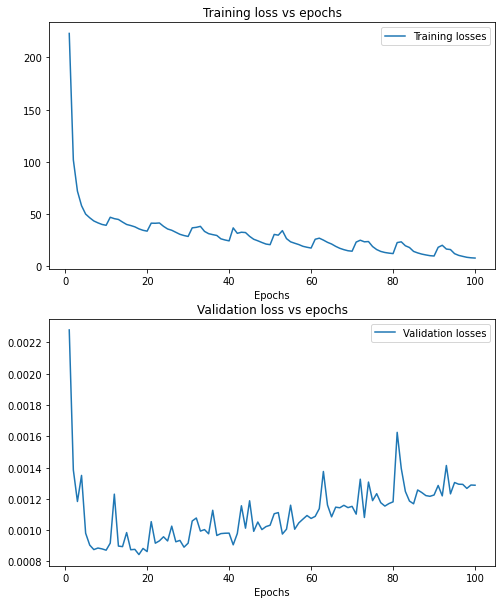

In [ ]:
# fig, (axe1, axe2) = plt.subplots(2)
fig = plt.figure(figsize=(8, 10), facecolor=(1, 1, 1))

axe1 = fig.add_subplot(2, 1, 1)
axe1.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
axe1.set_title('Training loss vs epochs')
axe1.set_xlabel('Epochs')
plt.legend()


axe2 = fig.add_subplot(2, 1, 2)
axe2.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
axe2.set_title('Validation loss vs epochs')
axe2.set_xlabel('Epochs')
plt.legend()

fig.savefig('model'+ model_args['model_num'] + '_loss.png')

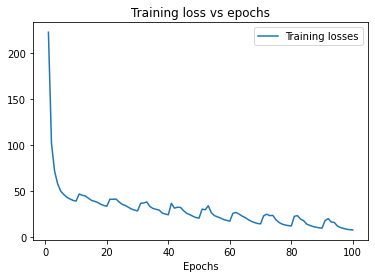

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Training loss vs epochs')
plt.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_training_loss.png', dpi=300)

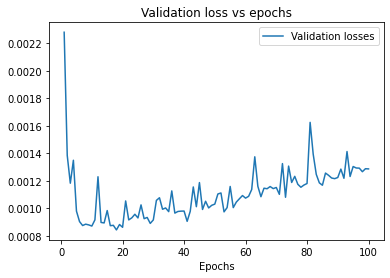

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Validation loss vs epochs')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_validation_loss.png', dpi=300)

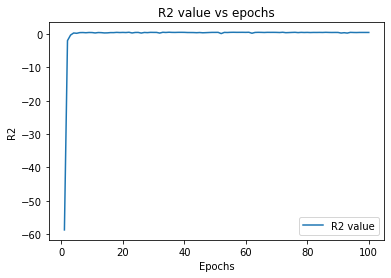

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('R2 value vs epochs')
plt.plot(range(1, epochs + 1), r2_list, label='R2 value')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_r2.png', dpi=300)